# Tumor Detection
---

In [27]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import random
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism
from tqdm.notebook import tqdm

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/miniconda3/envs/AI/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.15.2
Pillow version: 11.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.1
pandas version: 2.2.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd versi

In [28]:
# Random seed
seed = 42

## Setup data directory

In [29]:
data_path = "data/"
# data_path = r"../../"
train_path = data_path + "NCT-CRC-HE-100K"
test_path = data_path + "CRC-VAL-HE-7K"

## Set deterministic training for reproducibility

In [30]:
set_determinism(seed=seed)

## Train data

In [31]:
class_names = ["healthy", "tumor"]
num_class = len(class_names)
folders = sorted(os.listdir(train_path))
image_files = [[], []]

# Separate dataset into healthy and tumor
for i in range(len(folders)):
    for file in os.listdir(os.path.join(train_path, folders[i])):
        if folders[i] == "TUM":
            image_files[1].append(os.path.join(train_path, folders[i], file))
        else:
            image_files[0].append(os.path.join(train_path, folders[i], file))

num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 100000
Image dimensions: 224 x 224
Label names: ['healthy', 'tumor']
Label counts: [85683, 14317]


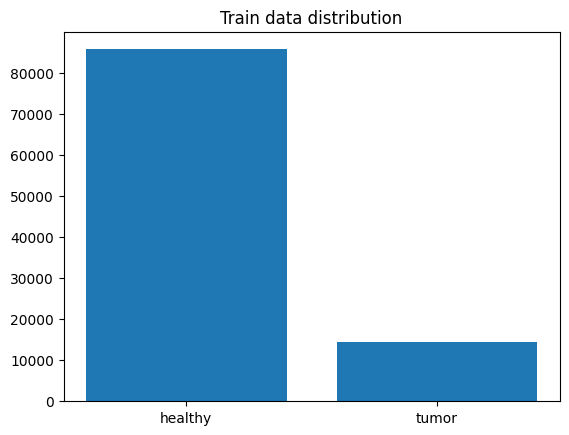

In [32]:
# Plot train data distribution
plt.figure()
plt.bar(class_names, num_each)
plt.title("Train data distribution")
plt.show()

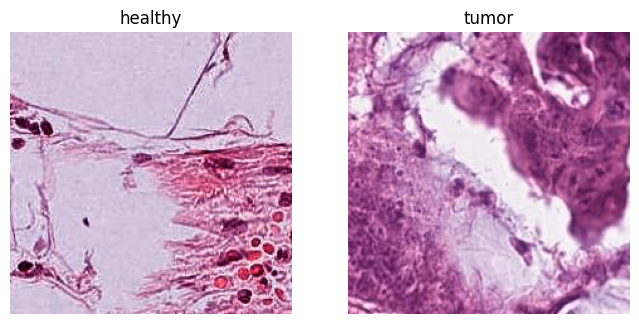

In [33]:
# Plot an image from each class
plt.figure(figsize=(8, 4))
for i in range(num_class):
    plt.subplot(1, num_class, i + 1)
    plt.imshow(PIL.Image.open(image_files[i][0]))
    plt.title(class_names[i])
    plt.axis("off")
plt.show()

## Undersampling: Dataset Balancing

BALANCEAR HEALTHY ANTES DE UNDERSAMPLING PARA QUE HAYA MISMO NUMERO DE IMAGENES DE CADA TEJIDO SANO?

Class with less samples: tumor with 14317 images
---
healthy    Taking 14317 from initial 85683 samples
tumor      Taking 14317 from initial 14317 samples
---
Total number of images: 28634


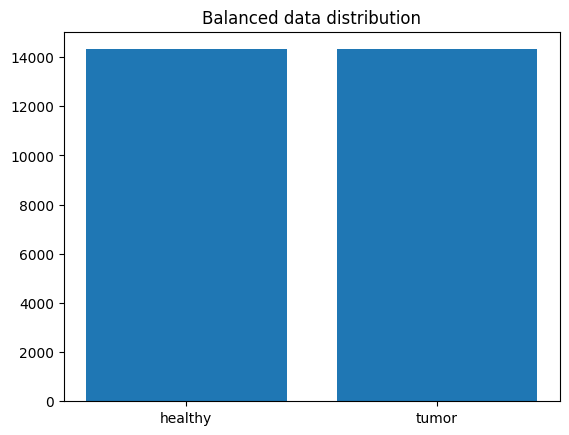

In [34]:
num_min_class = min(num_each)
print(f"Class with less samples: {class_names[np.argmin(num_each)]} with {num_min_class} images")
print("---")
balanced_image_files_list = []
balanced_image_class = []
for i in range(num_class):
    print(f"{class_names[i]:<10} Taking {num_min_class} from initial {len(image_files[i])} samples")
    balanced_image_files_list.extend(random.sample(image_files[i], num_min_class))
    balanced_image_class.extend([i] * num_min_class)

print("---")
print(f"Total number of images: {len(balanced_image_class)}")

# Plot balanced data distribution
plt.figure()
plt.bar(class_names, [balanced_image_class.count(i) for i in range(num_class)])
plt.title("Balanced data distribution")
plt.show()

{'STR': 1761, 'BACK': 1855, 'ADI': 1656, 'LYM': 1939, 'DEB': 1876, 'NORM': 1416, 'MUS': 2334, 'MUC': 1480}


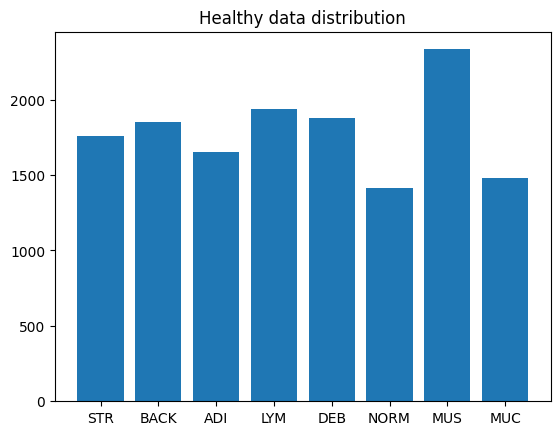

In [35]:
# Count images of each label in the healthy part
healthy_dist = {}
for img_file in balanced_image_files_list[:num_min_class]:
    label = img_file.split("/")[-2]
    if label not in healthy_dist:
        healthy_dist[label] = 0
    healthy_dist[label] += 1

print(healthy_dist)

# Plot healthy data distribution
plt.figure()
plt.bar(healthy_dist.keys(), healthy_dist.values())
plt.title("Healthy data distribution")
plt.show()

## Prepare training and validation splits

Training count: 22908, Validation count: 5726


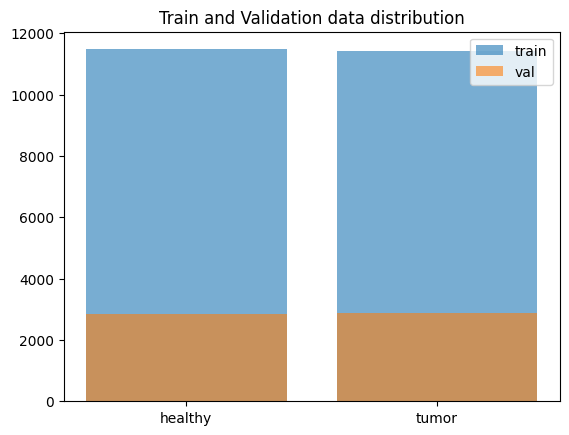

In [36]:
val_frac = 0.2
length = len(balanced_image_files_list)
indices = np.arange(length)
# Set seed for reproducibility
np.random.seed(seed)
np.random.shuffle(indices)

val_split = int(val_frac * length)
val_indices = indices[:val_split]
train_indices = indices[val_split:]

train_x = [balanced_image_files_list[i] for i in train_indices]
train_y = [balanced_image_class[i] for i in train_indices]
val_x = [balanced_image_files_list[i] for i in val_indices]
val_y = [balanced_image_class[i] for i in val_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}")

# Plot train and validation data distribution
plt.figure()
plt.bar(class_names, [train_y.count(i) for i in range(num_class)], alpha=0.6, label="train")
plt.bar(class_names, [val_y.count(i) for i in range(num_class)], alpha=0.6, label="val")
plt.title("Train and Validation data distribution")
plt.legend()
plt.show()

## Define transforms, Dataset and Dataloader to pre-process data

Preprocess and data augmentation:

In [ ]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        # Data augmentation:
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

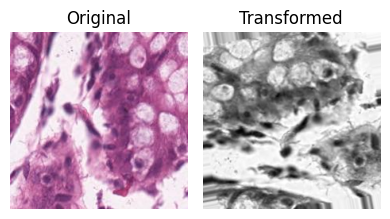

In [38]:
# Example of original and transformed image
plt.figure(figsize=(4, 4))

trans = train_transforms(train_x[1])
orig = PIL.Image.open(train_x[1])

plt.subplot(1, 2, 1)
plt.imshow(orig)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(trans[0], cmap="gray")
plt.title("Transformed")
plt.axis("off")
plt.tight_layout()
plt.show()

In [39]:
class TissuesDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = TissuesDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=10)
print("Number of train batches:", len(train_loader))

val_ds = TissuesDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, num_workers=10)
print("Number of validation batches:", len(val_loader))

Number of train batches: 358
Number of validation batches: 90


## Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
1. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
1. Use DenseNet from MONAI and move to GPU device.
1. Use Adam optimizer.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=num_class, pretrained=True).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

Device: cuda
NVIDIA GeForce RTX 3090


## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [41]:
models_path = "models/"

In [42]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
#    print("-" * 10)
#    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    train_progress = tqdm(train_loader, desc=f"Epoch {epoch + 1} Training", leave=True)
    for batch_data in train_progress:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
#        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
#    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            val_progress = tqdm(val_loader, desc=f"Epoch {epoch + 1} Validation", leave=True)
            for val_data in val_progress:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(models_path, "best_binary_model.pth"))
            print(
                f"Epoch: {epoch + 1} Validation AUC: {result:.4f}"
                f" Validation accuracy: {acc_metric:.4f}"
                f" Best AUC: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )

print("---")
print(f"Training completed")
print(f"Best validation AUC: {best_metric:.4f} at epoch: {best_metric_epoch}")

Epoch 1 Training:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 1 Validation AUC: 0.9980 Validation accuracy: 0.9825 Best AUC: 0.9980 at epoch: 1


Epoch 2 Training:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 2 Validation AUC: 0.9990 Validation accuracy: 0.9879 Best AUC: 0.9990 at epoch: 2


Epoch 3 Training:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 3 Validation AUC: 0.9992 Validation accuracy: 0.9902 Best AUC: 0.9992 at epoch: 3


Epoch 4 Training:   0%|          | 0/358 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch: 4 Validation AUC: 0.9995 Validation accuracy: 0.9907 Best AUC: 0.9995 at epoch: 4
---
Training completed
Best validation AUC: 0.9995 at epoch: 4


## Plot the loss and metric

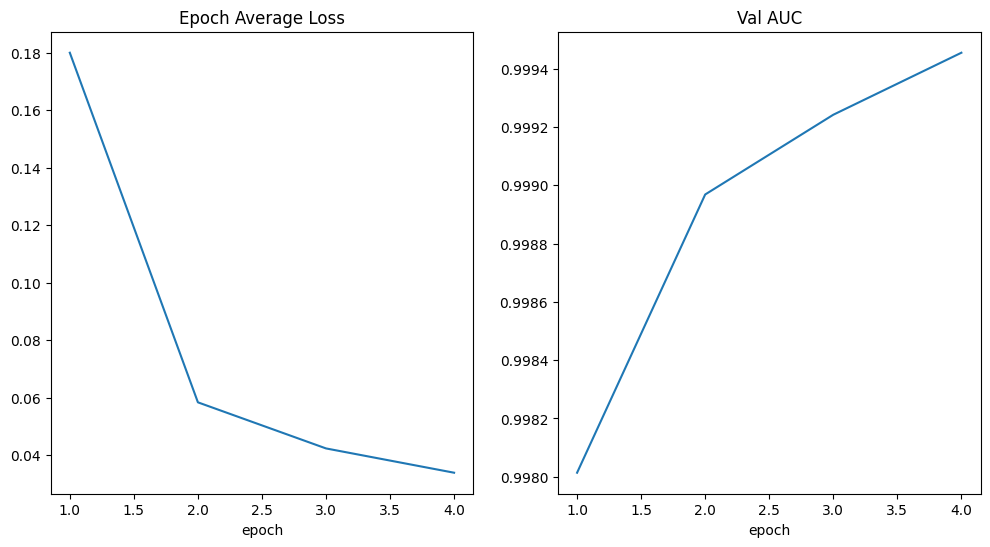

In [43]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluation with test data

In [53]:
class_names = ["healthy", "tumor"]
num_class = len(class_names)
folders = sorted(os.listdir(test_path))
test_image_files = [[], []]

# Separate dataset into healthy and tumor
for i in range(len(folders)):
    for file in os.listdir(os.path.join(test_path, folders[i])):
        if folders[i] == "TUM":
            test_image_files[1].append(os.path.join(test_path, folders[i], file))
        else:
            test_image_files[0].append(os.path.join(test_path, folders[i], file))

num_each = [len(test_image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(test_image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 7180
Image dimensions: 224 x 224
Label names: ['healthy', 'tumor']
Label counts: [5947, 1233]


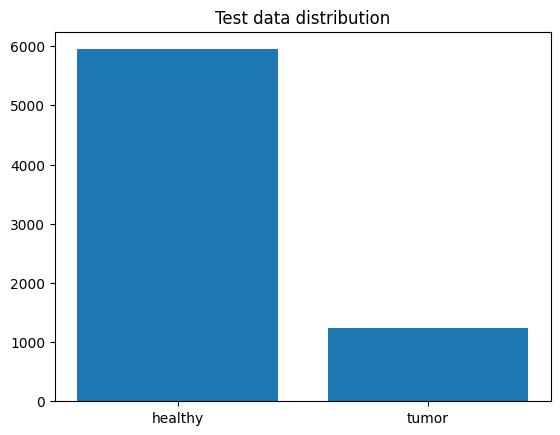

In [54]:
# Plot train data distribution
plt.figure()
plt.bar(class_names, num_each)
plt.title("Test data distribution")
plt.show()

In [55]:
test_ds = TissuesDataset(image_files_list, image_class, val_transforms)
test_loader = DataLoader(test_ds, batch_size=64, num_workers=10)
print("Number of test batches:", len(test_loader))

Number of test batches: 113


In [56]:
model.load_state_dict(torch.load(os.path.join(models_path, "best_binary_model.pth")))
model.eval()
print("Model loaded")

y_true = []
y_pred = []
with torch.no_grad():
    test_progress = tqdm(test_loader, desc=f"Test evaluation", leave=True)
    for test_data in test_progress:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

Model loaded


Test evaluation:   0%|          | 0/113 [00:00<?, ?it/s]

In [57]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

     healthy     0.9913    0.9941    0.9927      5947
       tumor     0.9712    0.9578    0.9645      1233

    accuracy                         0.9879      7180
   macro avg     0.9812    0.9760    0.9786      7180
weighted avg     0.9878    0.9879    0.9878      7180



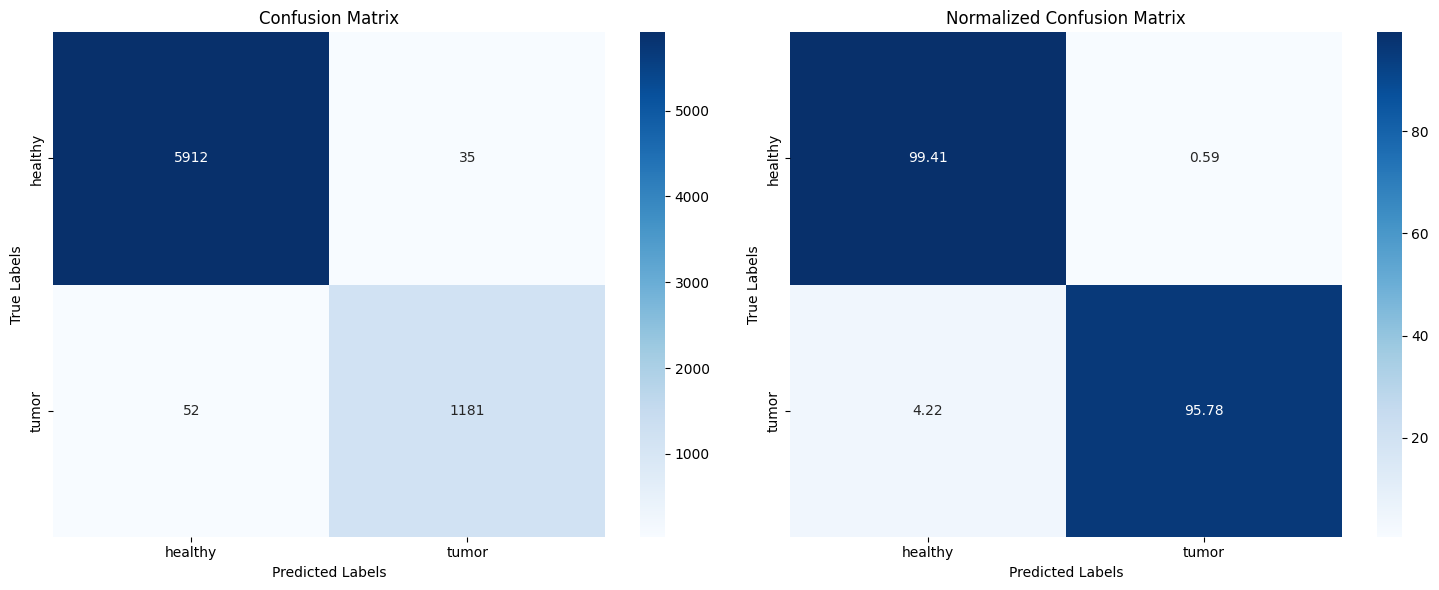

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Example confusion matrix (replace with your actual values)
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix and normalized confusion matrix in subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0], xticklabels=class_names, yticklabels=class_names)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted Labels")
ax[0].set_ylabel("True Labels")
cm_norm = (cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]) * 100
sns.heatmap(cm_norm, annot=True, cmap="Blues", ax=ax[1], xticklabels=class_names, yticklabels=class_names, fmt=".2f")
ax[1].set_title("Normalized Confusion Matrix")
ax[1].set_xlabel("Predicted Labels")
ax[1].set_ylabel("True Labels")
plt.tight_layout()
plt.show()

## Activation maps

In [59]:
# Get layer names
for name, _ in model.named_modules(): print(name)


features
features.conv0
features.norm0
features.relu0
features.pool0
features.denseblock1
features.denseblock1.denselayer1
features.denseblock1.denselayer1.layers
features.denseblock1.denselayer1.layers.norm1
features.denseblock1.denselayer1.layers.relu1
features.denseblock1.denselayer1.layers.conv1
features.denseblock1.denselayer1.layers.norm2
features.denseblock1.denselayer1.layers.relu2
features.denseblock1.denselayer1.layers.conv2
features.denseblock1.denselayer2
features.denseblock1.denselayer2.layers
features.denseblock1.denselayer2.layers.norm1
features.denseblock1.denselayer2.layers.relu1
features.denseblock1.denselayer2.layers.conv1
features.denseblock1.denselayer2.layers.norm2
features.denseblock1.denselayer2.layers.relu2
features.denseblock1.denselayer2.layers.conv2
features.denseblock1.denselayer3
features.denseblock1.denselayer3.layers
features.denseblock1.denselayer3.layers.norm1
features.denseblock1.denselayer3.layers.relu1
features.denseblock1.denselayer3.layers.conv1


In [60]:
from monai.visualize import CAM, GradCAMpp

model.to(device)
model.load_state_dict(torch.load(os.path.join(models_path, "best_binary_model.pth"), weights_only=True))
model.eval()
model_2d = model

gradcampp = GradCAMpp(model, target_layers="class_layers.relu")
cam = CAM(nn_module=model_2d, target_layers="class_layers.relu", fc_layers="class_layers.out")

In [61]:
def plot_cams(orig_image, label):
    image = val_transforms(orig_image)
    image = image.unsqueeze(0).to(device)

    # Get the prediction
    pred = model(image).argmax(dim=1)
    print(f"Prediction: {pred.item()} ({class_names[pred.item()]}) | Real Label: {label} | Class: {class_names[label]}")

    # Rotate the image 90 degrees
    image = torch.rot90(image, -1, [2, 3])
    # Flip the image horizontally
    image = torch.flip(image, [3])
    
    # GradCAM++
    gradcam_map = gradcampp(image, label)
    gradcam_map = gradcam_map[0].cpu().numpy()
    gradcam_map = np.transpose(gradcam_map, (1, 2, 0))
    gradcam_map = np.maximum(gradcam_map, 0)
    gradcam_map = gradcam_map / gradcam_map.max()

    # CAM
    label = torch.tensor([label]).to(device)
    cam_map = cam(image, label)
    cam_map = cam_map[0].cpu().numpy()
    cam_map = np.transpose(cam_map, (1, 2, 0))
    cam_map = np.maximum(cam_map, 0)
    cam_map = cam_map / cam_map.max()

    # Plot the original image, GradCAM++ and CAM
    orig_image = PIL.Image.open(orig_image)
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(orig_image)
    plt.title(f"Original ({class_names[label]})")
    plt.axis("off") 

    plt.subplot(1, 3, 2)
    plt.imshow(gradcam_map, cmap="jet")
    plt.imshow(image[0][0].cpu(), cmap="gray", alpha=0.5)
    plt.title("GradCAM++")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cam_map, cmap="jet")
    plt.imshow(image[0][0].cpu(), cmap="gray", alpha=0.5)
    plt.title("CAM")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

### CAM for all classes

Prediction: 0 (healthy) | Real Label: 0 | Class: healthy


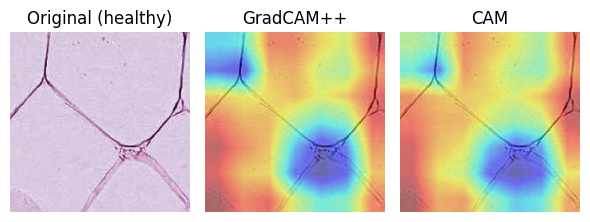

Prediction: 1 (tumor) | Real Label: 1 | Class: tumor


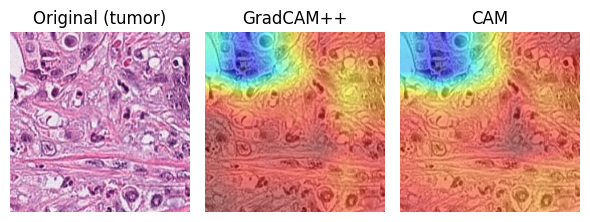

In [63]:
test_img_idx = 1

for i in range(num_class):
    image = image_files[i][test_img_idx]
    label = i

    plot_cams(image, label)

### Wrong Tumor predictions

Tumor labeled images predicted as Healthy.

Prediction: 0 (healthy) | Real Label: 1 | Class: tumor


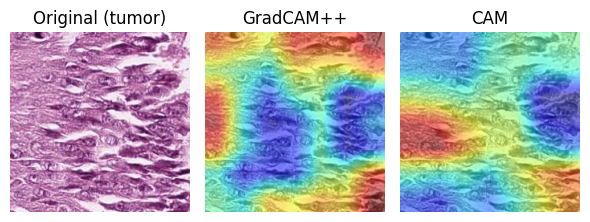

Prediction: 0 (healthy) | Real Label: 1 | Class: tumor


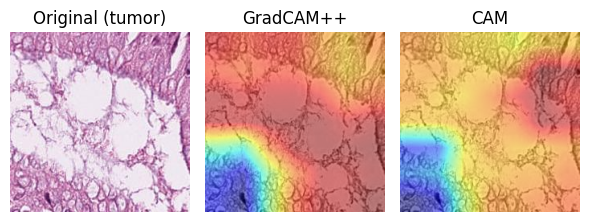

Prediction: 0 (healthy) | Real Label: 1 | Class: tumor


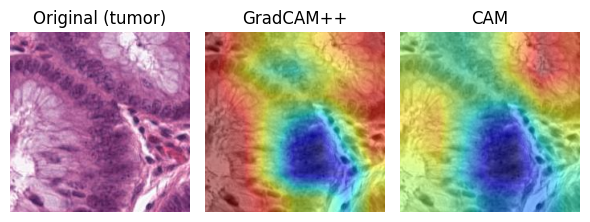

Prediction: 0 (healthy) | Real Label: 1 | Class: tumor


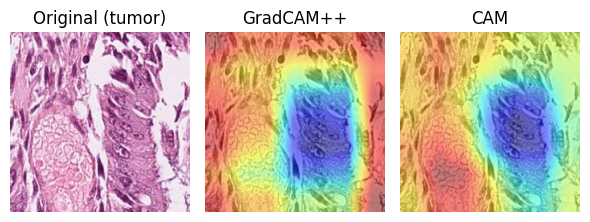

Prediction: 0 (healthy) | Real Label: 1 | Class: tumor


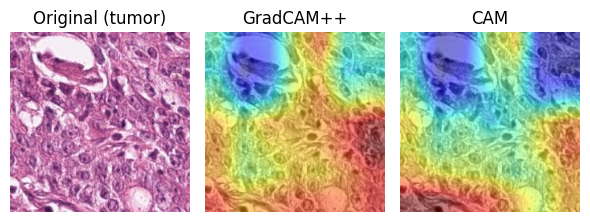

In [64]:
healthy_label = 0 # healthy
tumor_label = 1 # tumor

# Get 5 wrong predictions for the tumor class
wrong_preds = []
for i in range(len(y_true)):
    if y_true[i] == tumor_label and y_pred[i] == healthy_label:
        wrong_preds.append(i)
    if len(wrong_preds) == 5:
        break

# Plot GradCAM++ and CAM for the wrong predictions
for i in wrong_preds:
    image = image_files_list[i]
    label = y_true[i]

    plot_cams(image, label)